In [1]:
import gym
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:

# Load and preprocess the training data
train_data = pd.read_csv('train_data.csv', parse_dates=['date'], index_col='date')

# Data Preprocessing (Adding EWMA and Rolling Mean)
train_data['EWMA'] = train_data['close'].ewm(span=20, adjust=False).mean()  # Exponentially Weighted Moving Average
train_data['Rolling_Mean'] = train_data['close'].rolling(window=20).mean()  # Simple Moving Average
train_data['Returns'] = train_data['close'].pct_change()  # Calculate returns
train_data['Returns'] = train_data['Returns'] * 1000  # Scale returns
train_data.dropna(inplace=True)  # Drop NaNs caused by rolling and returns calculations

# Prepare Data for Linear Regression
features = train_data[['close', 'EWMA', 'Rolling_Mean']].dropna()

# Define the target variable (close price)
X_train = features[['EWMA', 'Rolling_Mean']]
y_train = features['close']

# Build and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [3]:

# Load and preprocess the test data
test_data = pd.read_csv('test_data.csv', parse_dates=['date'], index_col='date')
test_data['EWMA'] = test_data['close'].ewm(span=20, adjust=False).mean()
test_data['Rolling_Mean'] = test_data['close'].rolling(window=20).mean()
test_data['Returns'] = test_data['close'].pct_change()
test_data.dropna(inplace=True)

# Prepare Test Data for Prediction
test_features = test_data[['close', 'EWMA', 'Rolling_Mean']].dropna()
X_test = test_features[['EWMA', 'Rolling_Mean']]

# Make Predictions on Test Data
predicted_close_prices = model.predict(X_test)

# Add predictions to test data
test_data['Predicted_Close'] = np.nan
test_data.iloc[-len(predicted_close_prices):, test_data.columns.get_loc('Predicted_Close')] = predicted_close_prices

In [4]:

# Define the percentage accuracy function
def percentage_accuracy(y_true, y_pred, threshold=0.05):
    percentage_error = np.abs((y_true - y_pred) / y_true)  # Calculate percentage error
    return np.mean(percentage_error < threshold) * 100  # Percentage of predictions within threshold

# Align data for MSE calculation
aligned_test_data = test_data[['close', 'Predicted_Close']].dropna()
mse = mean_squared_error(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
mae = mean_absolute_error(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
r2 = r2_score(aligned_test_data['close'], aligned_test_data['Predicted_Close'])
accuracy = percentage_accuracy(aligned_test_data['close'], aligned_test_data['Predicted_Close'], threshold=0.05)  # 5% threshold

# Print the results
print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R²) on Test Data: {r2}")
print(f"Percentage Accuracy on Test Data (within 5%): {accuracy}%")

Mean Squared Error (MSE) on Test Data: 7503.347039422594
Mean Absolute Error (MAE) on Test Data: 56.78655090404487
R-squared (R²) on Test Data: 0.9999099958474059
Percentage Accuracy on Test Data (within 5%): 99.99859658314777%


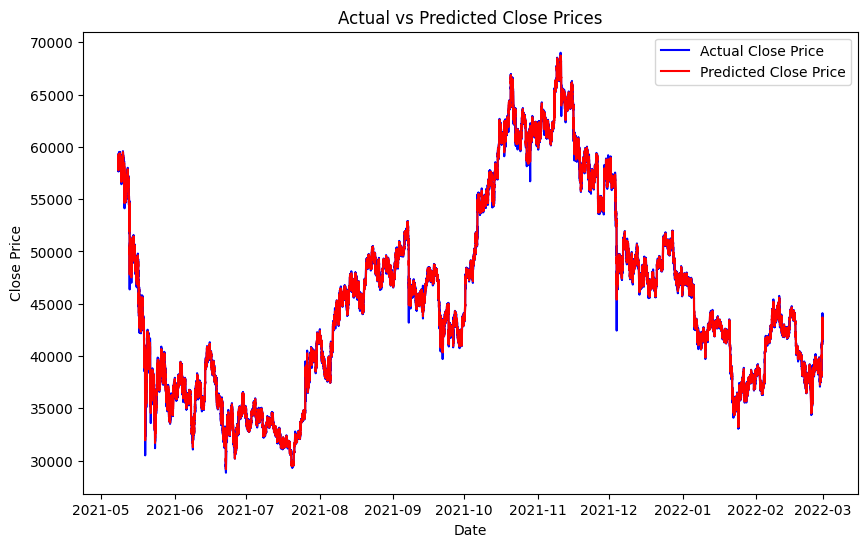

In [5]:

# Visualize the Predictions
plt.figure(figsize=(10, 6))
plt.plot(aligned_test_data['close'], label='Actual Close Price', color='blue')
plt.plot(aligned_test_data['Predicted_Close'], label='Predicted Close Price', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
